In [ ]:
#Upload Data
from google.colab import files
import os
uploaded = files.upload()

Saving admissions.csv to admissions.csv
Saving diagnoses_icd.csv.gz to diagnoses_icd.csv.gz
Saving icustays.csv to icustays.csv
Saving patients.csv to patients.csv


In [ ]:
!pip install pandasql
import pandasql as ps

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_recall_curve, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE



admissions_df = pd.read_csv('admissions.csv')
icustays_df = pd.read_csv('icustays.csv')
patients_df = pd.read_csv('patients.csv')
diagnoses_df = pd.read_csv('diagnoses_icd.csv.gz', compression='gzip')

print("\n--- Data Loading Complete ---\n")
print(f"Admissions Table Size: {admissions_df.shape[0]:,} rows")
print(f"ICU Stays Table Size: {icustays_df.shape[0]:,} rows")
print(f"Diagnoses Table Size: {diagnoses_df.shape[0]:,} rows")
print(f"Patients Table Size: {patients_df.shape[0]:,} rows")

print("\n--- Sample of Admissions Data ---")
print(admissions_df.head())



--- Data Loading Complete ---

Admissions Table Size: 546,028 rows
ICU Stays Table Size: 94,458 rows
Diagnoses Table Size: 6,364,488 rows
Patients Table Size: 364,627 rows

--- Sample of Admissions Data ---
   subject_id   hadm_id            admittime            dischtime deathtime  \
0    10000032  22595853  2180-05-06 22:23:00  2180-05-07 17:15:00       NaN   
1    10000032  22841357  2180-06-26 18:27:00  2180-06-27 18:49:00       NaN   
2    10000032  25742920  2180-08-05 23:44:00  2180-08-07 17:50:00       NaN   
3    10000032  29079034  2180-07-23 12:35:00  2180-07-25 17:55:00       NaN   
4    10000068  25022803  2160-03-03 23:16:00  2160-03-04 06:26:00       NaN   

   admission_type admit_provider_id      admission_location  \
0          URGENT            P49AFC  TRANSFER FROM HOSPITAL   
1        EW EMER.            P784FA          EMERGENCY ROOM   
2        EW EMER.            P19UTS          EMERGENCY ROOM   
3        EW EMER.            P06OTX          EMERGENCY ROOM   
4 

  gender  count
0      M  10464
1      F   7456


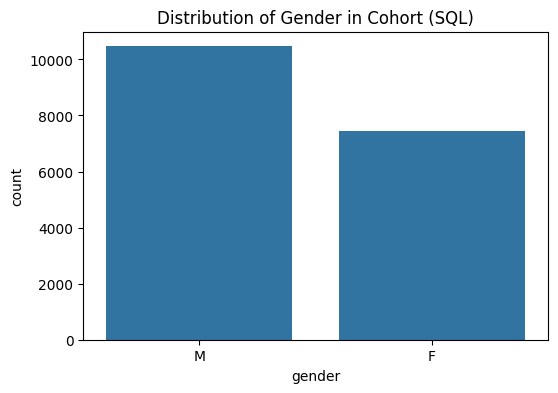

In [ ]:
# Visualization of gender distribution

query = """
    SELECT gender, COUNT(*) as count
    FROM icu_full
    GROUP BY gender
    ORDER BY count DESC
"""
gender_counts = ps.sqldf(query, locals())

print(gender_counts)


plt.figure(figsize=(6, 4))
sns.barplot(x='gender', y='count', data=gender_counts)
plt.title('Distribution of Gender in Cohort (SQL)')
plt.show()

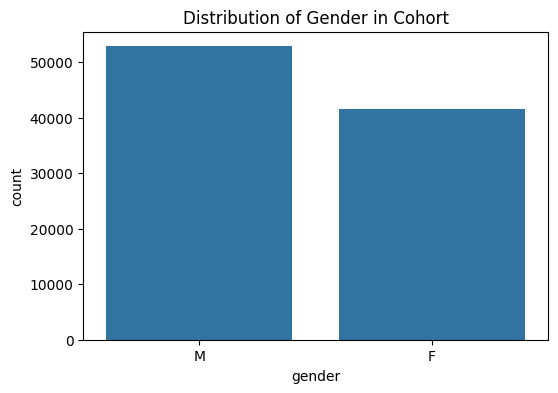

In [ ]:
#Convert column names to lowercase for consistency
admissions_df.columns = admissions_df.columns.str.lower()
icustays_df.columns = icustays_df.columns.str.lower()
patients_df.columns = patients_df.columns.str.lower()

#Merge ICU, Admissions, and Patient Data

icu_full = icustays_df.merge(
    admissions_df, on=['hadm_id', 'subject_id'], how='left'
).merge(
    patients_df, on=['subject_id'], how='left'
)

#Visualize gender distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='gender', data=icu_full, order=icu_full['gender'].value_counts().index)
plt.title('Distribution of Gender in Cohort')

plt.show()

In [ ]:
# Check for missing values after merge
print("\nChecking missing data:")
missing_pct = icu_full.isnull().sum() / len(icu_full) * 100
missing_data = missing_pct[missing_pct > 0].sort_values(ascending=False)
print(missing_data.head(10).round(2).astype(str) + '%')

# Clean Age and Missing Data
# Rename age column and drop rows with missing age
icu_full.rename(columns={'anchor_age': 'age'}, inplace=True)
icu_full.dropna(subset=['age'], inplace=True)

# Filter for Primary Cardiovascular ICU Admissions
# Create 3-character ICD code for filtering
diagnoses_df['icd_code_3char'] = diagnoses_df['icd_code'].astype(str).str[:3]

# Define primary cardiovascular ICD codes (I00-I99) and filter diagnoses
primary_codes = [f'I{str(i).zfill(2)}' for i in range(0, 100)]
primary_cv_diagnoses = diagnoses_df[
    (diagnoses_df['icd_code_3char'].isin(primary_codes)) &
    (diagnoses_df['seq_num'] == 1)
]
# Keep only ICU stays associated with a primary cardiovascular diagnosis
cardio_adm_ids = primary_cv_diagnoses['hadm_id'].unique()
icu_full = icu_full[icu_full['hadm_id'].isin(cardio_adm_ids)].copy()
print(f"Filtered to Cardiovascular ICU stays: {icu_full.shape[0]:,} records.")

# Check Missing Data
missing_pct = icu_full.isnull().sum() / len(icu_full) * 100
missing_data = missing_pct[missing_pct > 0].sort_values(ascending=False)
print("Top Missing Columns (Percentage of NaN):")
print(missing_data.head(10).round(2).astype(str) + '%')

# Handle Missing Data
# Impute numerics with median and categoricals with mode
numeric_cols = icu_full.select_dtypes(include=['number']).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != 'age'] # Exclude 'age' as it was already cleaned
icu_full[numeric_cols] = icu_full[numeric_cols].fillna(icu_full[numeric_cols].median())

categorical_cols = icu_full.select_dtypes(include=['object']).columns.tolist()
icu_full[categorical_cols] = icu_full[categorical_cols].fillna(icu_full[categorical_cols].mode().iloc[0])



# Define Comorbidity Codes for Feature Engineering
comorbidity_map = {
    'heart_failure': ['I50', '428'],
    'myocardial_infarction': ['I21', '410'],
    'coronary_artery_disease': ['I25', '414'],
    'atrial_fibrillation': ['I48'],
    'peripheral_vascular_disease': ['I73'],
    'stroke_tia': ['I63', 'I69'],
    'hypertension': ['I10'],
    'diabetes': ['E10','E11','E12','E13','E14'],
    'ckd': ['N18'],
    'copd': ['J44']
}


Checking missing data:
deathtime             87.99%
dod                   59.81%
edregtime             34.23%
edouttime             34.23%
marital_status         8.22%
insurance              1.61%
discharge_location      0.9%
language               0.42%
outtime                0.01%
los                    0.01%
dtype: object
Filtered to Cardiovascular ICU stays: 17,920 records.
Top Missing Columns (Percentage of NaN):
deathtime             90.83%
dod                   71.33%
edregtime             48.97%
edouttime             48.97%
marital_status        11.88%
insurance              1.26%
discharge_location     0.64%
language               0.12%
outtime                0.01%
los                    0.01%
dtype: object


In [ ]:
# Prepare Dataset for Modeling
# Create a copy of the ICU dataset to use for predictive modeling
df_modeling = icu_full.copy()

# Drop high-cardinality or unnecessary columns that may not be useful for modeling
drop_cols = [
    'admit_provider_id',  # provider identifier (too many unique values)
    'admission_location', # location info may not add predictive value
    'discharge_location',
    'insurance',
    'marital_status',
    'language'
]
df_modeling = df_modeling.drop(columns=drop_cols, errors='ignore')

# Print dataset shape and remaining columns to confirm changes
print("Dataset shape after dropping columns:", df_modeling.shape)
print("Remaining columns:", df_modeling.columns.tolist())

Dataset shape after dropping columns: (17920, 21)
Remaining columns: ['subject_id', 'hadm_id', 'stay_id', 'first_careunit', 'last_careunit', 'intime', 'outtime', 'los', 'admittime', 'dischtime', 'deathtime', 'admission_type', 'race', 'edregtime', 'edouttime', 'hospital_expire_flag', 'gender', 'age', 'anchor_year', 'anchor_year_group', 'dod']


In [ ]:
# Column Separation and Preprocessing
# Separate columns by type
# Identify numeric, datetime, and categorical columns for preprocessing
numeric_cols = df_modeling.select_dtypes(include=['number']).columns.tolist()
datetime_cols = df_modeling.select_dtypes(include=['datetime64[ns]']).columns.tolist()
categorical_cols = df_modeling.select_dtypes(include=['object']).columns.tolist()
print("Numeric columns:", numeric_cols)
print("Datetime columns:", datetime_cols)
print("Categorical columns:", categorical_cols)

# Convert datetime columns to numeric timestamps
# Convert datetime to integer seconds for modeling purposes
for col in datetime_cols:
    df_modeling[col] = df_modeling[col].astype('int64') // 10**9
print("Datetime columns converted to numeric.")

# Impute missing numeric and datetime values
imputer = SimpleImputer(strategy='median')
df_modeling[numeric_cols + datetime_cols] = imputer.fit_transform(df_modeling[numeric_cols + datetime_cols])
print("Numeric and datetime columns imputed.")

# Encode low-cardinality categorical variables
# Define "low-cardinality" as <= 10 unique values
low_card_cols = [c for c in categorical_cols if df_modeling[c].nunique() <= 10]
high_card_cols = [c for c in categorical_cols if df_modeling[c].nunique() > 10]
print("Low-cardinality categorical columns:", low_card_cols)
print("High-cardinality categorical columns (kept as-is):", high_card_cols)

# One-hot encode low-cardinality categorical columns
df_modeling_encoded = pd.get_dummies(df_modeling, columns=low_card_cols, drop_first=True)
print("Block 2 complete. Dataset shape after encoding and imputation:", df_modeling_encoded.shape)

Numeric columns: ['subject_id', 'hadm_id', 'stay_id', 'los', 'hospital_expire_flag', 'age', 'anchor_year']
Datetime columns: []
Categorical columns: ['first_careunit', 'last_careunit', 'intime', 'outtime', 'admittime', 'dischtime', 'deathtime', 'admission_type', 'race', 'edregtime', 'edouttime', 'gender', 'anchor_year_group', 'dod']
Datetime columns converted to numeric.
Numeric and datetime columns imputed.
Low-cardinality categorical columns: ['admission_type', 'gender', 'anchor_year_group']
High-cardinality categorical columns (kept as-is): ['first_careunit', 'last_careunit', 'intime', 'outtime', 'admittime', 'dischtime', 'deathtime', 'race', 'edregtime', 'edouttime', 'dod']
Block 2 complete. Dataset shape after encoding and imputation: (17920, 30)


In [ ]:
# Handle High-Cardinality Columns
# Identify high-cardinality columns that require special handling
high_card_cols = [
    'first_careunit', 'last_careunit',
    'intime', 'outtime', 'admittime', 'dischtime',
    'deathtime', 'race', 'edregtime', 'edouttime', 'dod'
]

# Convert datetime columns to numeric timestamps (seconds)
# Ensures datetime information can be used in models
datetime_cols = [
    'intime', 'outtime', 'admittime', 'dischtime',
    'deathtime', 'edregtime', 'edouttime', 'dod'
]

for col in datetime_cols:
    df_modeling_encoded[col] = pd.to_datetime(df_modeling_encoded[col], errors='coerce').astype('int64') // 10**9

# Label encode remaining categorical high-cardinality columns
# Columns like care units and race are label-encoded to convert categories to numeric values
for col in ['first_careunit', 'last_careunit', 'race']:
    le = LabelEncoder()
    df_modeling_encoded[col] = le.fit_transform(df_modeling_encoded[col].astype(str))

# Check final shape after preprocessing
print("Block 3 complete. Dataset shape after handling high-cardinality columns:", df_modeling_encoded.shape)


Block 3 complete. Dataset shape after handling high-cardinality columns: (17920, 30)


Current raw feature count (including target): 30

--- Checking for Highly Correlated Features ---
Number of highly correlated feature pairs (|r| > 0.9): 12
          feature_1      feature_2  correlation
84   first_careunit  last_careunit     1.000000
282       edregtime      edouttime     1.000000
137          intime      admittime     1.000000
138          intime      dischtime     0.999999
204       admittime      dischtime     0.999999
135          intime        outtime     0.999922
160         outtime      admittime     0.999922
161         outtime      dischtime     0.999922
211       admittime    anchor_year     0.989701
145          intime    anchor_year     0.989697


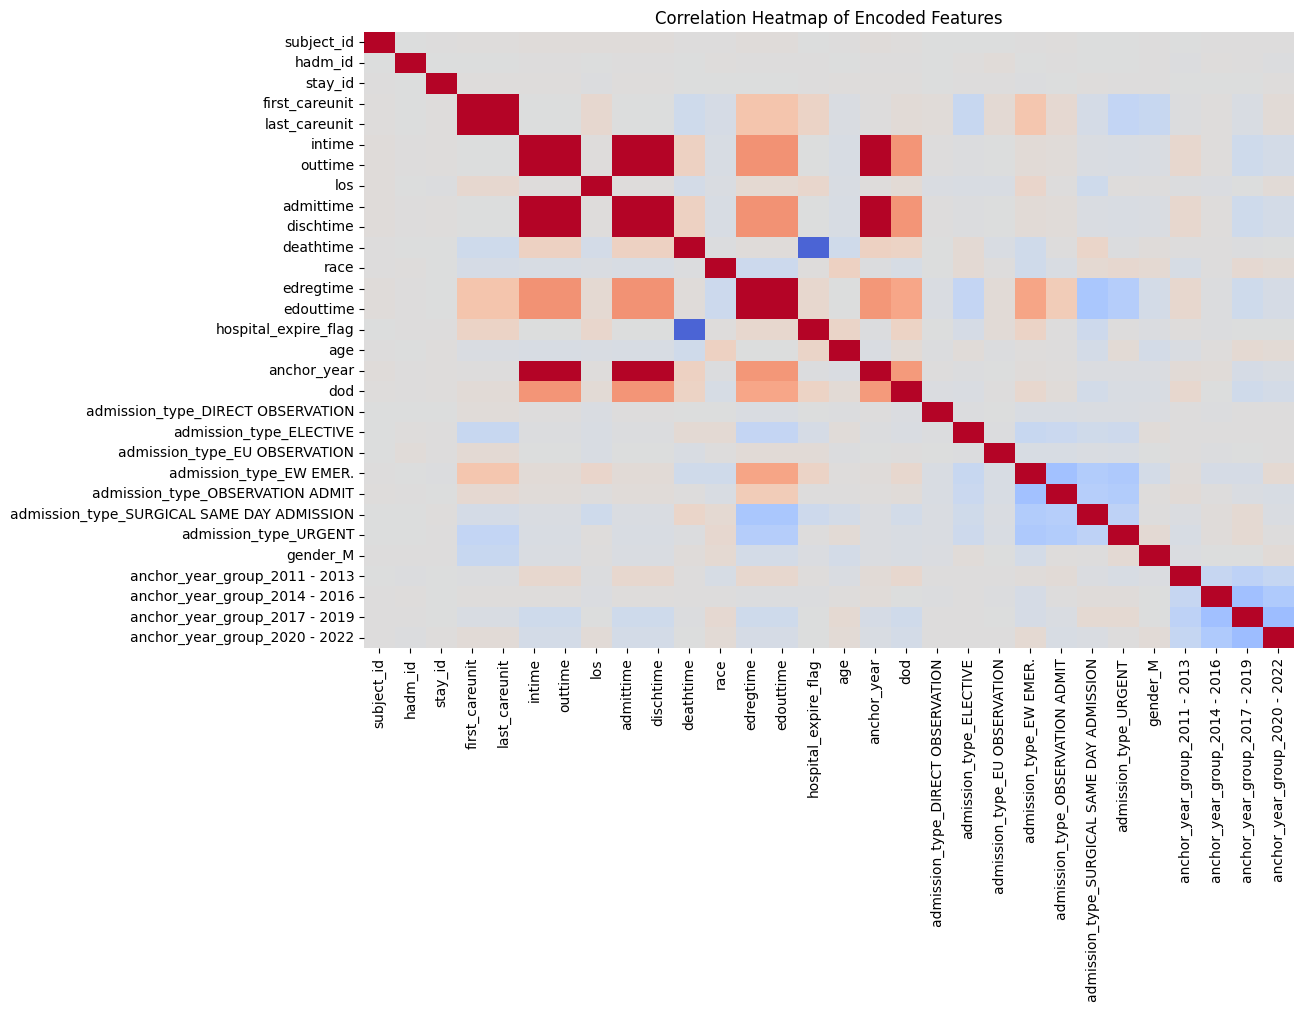

Index(['subject_id', 'hadm_id', 'stay_id', 'first_careunit', 'last_careunit',
       'intime', 'outtime', 'los', 'admittime', 'dischtime', 'deathtime',
       'race', 'edregtime', 'edouttime', 'hospital_expire_flag', 'age',
       'anchor_year', 'dod', 'admission_type_DIRECT OBSERVATION',
       'admission_type_ELECTIVE', 'admission_type_EU OBSERVATION',
       'admission_type_EW EMER.', 'admission_type_OBSERVATION ADMIT',
       'admission_type_SURGICAL SAME DAY ADMISSION', 'admission_type_URGENT',
       'gender_M', 'anchor_year_group_2011 - 2013',
       'anchor_year_group_2014 - 2016', 'anchor_year_group_2017 - 2019',
       'anchor_year_group_2020 - 2022'],
      dtype='object')


In [ ]:
# Check for Highly Correlated Features
# -----------------------------

# Create a copy of the encoded dataset for modeling
df_modeling = df_modeling_encoded.copy()

print(f"Current raw feature count (including target): {df_modeling.shape[1]}")

print("\n--- Checking for Highly Correlated Features ---")

# Compute correlation matrix for numeric features only
corr_matrix = df_modeling.corr(numeric_only=True)

# Identify pairs of features with correlation higher than threshold
threshold = 0.9  # correlation cutoff
high_corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
    .rename(columns={'level_0': 'feature_1', 'level_1': 'feature_2', 0: 'correlation'})
    .query('abs(correlation) > @threshold')
)

print(f"Number of highly correlated feature pairs (|r| > {threshold}): {len(high_corr_pairs)}")
if len(high_corr_pairs) > 0:
    print(high_corr_pairs.sort_values('correlation', ascending=False).head(10))
else:
    print("No major multicollinearity detected.")

# Optional: visualize correlation structure for numeric features
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, cbar=False)
plt.title('Correlation Heatmap of Encoded Features')
plt.show()

# --- Optional: Function to drop highly correlated features ---
# Can be used to remove multicollinear features prior to modeling
def drop_high_corr_features(df, threshold=0.9):
    corr_matrix = df.corr(numeric_only=True).abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    print(f"Dropping {len(to_drop)} highly correlated features.")
    return df.drop(columns=to_drop, errors='ignore')

# Uncomment the next line only if you decide to drop highly correlated features
# df_modeling = drop_high_corr_features(df_modeling, threshold=0.9)

# Print final column list after correlation check
print(df_modeling.columns)

In [ ]:
# Prepare ICU Data for Modeling & Create Target

# Make a copy of the cleaned ICU dataset for modeling
df_modeling = icu_full.copy()
print(f"Initial feature count (including target placeholder): {df_modeling.shape[1]}")

# -----------------------------------------------------
# Step 1: Ensure datetime columns are proper datetime objects
# -----------------------------------------------------
datetime_cols = ['intime', 'outtime', 'admittime', 'dischtime']
for col in datetime_cols:
    df_modeling[col] = pd.to_datetime(df_modeling[col], errors='coerce')

# check for any missing datetimes
missing_dates = df_modeling[datetime_cols].isnull().sum()
print("Missing datetime values per column:")
print(missing_dates)

# -----------------------------------------------------
# Step 2: Sort by patient and ICU admission time
# -----------------------------------------------------
df_modeling = df_modeling.sort_values(['subject_id', 'intime']).copy()

# -----------------------------------------------------
# Step 3: Create next ICU admission column
# -----------------------------------------------------
df_modeling['next_intime'] = df_modeling.groupby('subject_id')['intime'].shift(-1)

# Ensure next_intime is also datetime
df_modeling['next_intime'] = pd.to_datetime(df_modeling['next_intime'], errors='coerce')

# -----------------------------------------------------
# Step 4: Calculate days until next admission
# -----------------------------------------------------
df_modeling['days_to_next_admit'] = (
    (df_modeling['next_intime'] - df_modeling['outtime']).dt.total_seconds() / (60*60*24)
)

# -----------------------------------------------------
# Step 5: Define 30-day readmission target
# -----------------------------------------------------
df_modeling['readmit_30d'] = (df_modeling['days_to_next_admit'] <= 30).astype(int)


Initial feature count (including target placeholder): 27
Missing datetime values per column:
intime       0
outtime      0
admittime    0
dischtime    0
dtype: int64


In [ ]:
# FEATURE ENGINEERING & ENCODING

# Steps are removing non-predictive identifiers, generating clinically
# relevant comorbidity flags, encoding categorical variables, and performing
# Also a light feature cleanup to ensure a clean numerical dataset for modeling.


redundant_cols = ['subject_id', 'stay_id', 'intime', 'outtime', 'admittime', 'dischtime']
df_modeling_model = df_modeling.drop(columns=redundant_cols, errors='ignore')


# Converts string categories into model-friendly binary features while avoiding
# unintended ordinal relationships.
categorical_cols = df_modeling_model.select_dtypes(include=['object']).columns.tolist()
df_modeling_encoded = pd.get_dummies(df_modeling_model, columns=categorical_cols, drop_first=True)

# Remove admission IDs after feature creation
# hadm_id is no longer needed once comorbidities are derived.
df_modeling_encoded = df_modeling_encoded.drop(columns=['hadm_id'], errors='ignore')

# Convert any remaining datetime features into numeric format
# Ensures full compatibility with machine learning algorithms.
datetime_cols = df_modeling_encoded.select_dtypes(include=['datetime64[ns]']).columns.tolist()
for col in datetime_cols:
    df_modeling_encoded[col] = df_modeling_encoded[col].astype('int64') // 10**9

# Light low-variance filtering
# Removes features with near-zero variance that provide minimal predictive value.

selector = VarianceThreshold(threshold=0.001)
X_reduced = selector.fit_transform(df_modeling_encoded)
selected_features = df_modeling_encoded.columns[selector.get_support()]
df_modeling_encoded = pd.DataFrame(X_reduced, columns=selected_features)

# Final dataset ready for model training
print(f"Final feature count after preprocessing: {df_modeling_encoded.shape[1]}")

# Drop columns that leak future info
leak_cols = ['next_intime', 'days_to_next_admit']
df_modeling_model = df_modeling.drop(columns=leak_cols + redundant_cols, errors='ignore')


Final feature count after preprocessing: 239


In [ ]:
print(f"Features (X) shape: {X_train_res.shape}")  # After SMOTE, or you could use X_train.shape before SMOTE
print(f"Target (y) shape: {y_train_res.shape}")    # After SMOTE, or use y_train.shape before SMOTE

# Optional: preview first few rows
print("\nSample of feature matrix (X_train_res):")
print(X_train_res.head())

print("\nSample of target variable (y_train_res):")
print(y_train_res.head())

Features (X) shape: (25590, 671)
Target (y) shape: (25590,)

Sample of feature matrix (X_train_res):
        los  hospital_expire_flag       age  anchor_year  heart_failure  \
0 -0.187494             -0.321502  0.332020    -1.716964      -0.769303   
1  1.116690             -0.321502 -1.471768     0.610991      -0.769303   
2 -0.370976             -0.321502 -0.822404     1.457520      -0.769303   
3 -0.124212             -0.321502  0.837080     1.796131      -0.769303   
4 -0.582935             -0.321502  0.259868    -0.277865      -0.769303   

   myocardial_infarction  coronary_artery_disease  atrial_fibrillation  \
0              -0.493976                 1.023147            -0.796073   
1              -0.493976                -0.977376            -0.796073   
2              -0.493976                 1.023147            -0.796073   
3              -0.493976                -0.977376            -0.796073   
4              -0.493976                -0.977376            -0.796073   

   

In [ ]:
# Assuming df_modeling contains: readmit_30d, next_intime, hadm_id, etc.
df_modeling_proc = df_modeling.copy()

# 1. Feature Engineering (Comorbidities)
# Use comorbidity_map and diagnoses_df from previous successful blocks
# Note: readmit_30d was created in a previous step, so we skip recreating it here.
for condition, codes in comorbidity_map.items():
    df_modeling_proc[condition] = df_modeling_proc['hadm_id'].isin(
        diagnoses_df[diagnoses_df['icd_code'].str[:3].isin(codes)]['hadm_id']
    ).astype(int)

# 2. Drop Identifiers & Leaky Future Info
leak_cols = [
    'subject_id', 'hadm_id', 'stay_id',
    'intime', 'outtime', 'admittime', 'dischtime',
    'deathtime', 'edregtime', 'edouttime', 'dod',
    'days_to_next_admit', 'next_intime'
]
df_modeling_proc = df_modeling_proc.drop(columns=[c for c in leak_cols if c in df_modeling_proc.columns], errors='ignore')

# 3. Encode Categorical Variables
categorical_cols = df_modeling_proc.select_dtypes(include=['object']).columns.tolist()
X = pd.get_dummies(df_modeling_proc, columns=categorical_cols, drop_first=True)
y = X['readmit_30d']
X = X.drop(columns=['readmit_30d'])

# 4. Impute NaNs (Final Cleanup before Split)
X = X.apply(pd.to_numeric, errors='coerce') # Ensure all types are numeric for ML
X = X.fillna(X.median())

# 5. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(f"X_train shape before SMOTE: {X_train.shape}")
print(f"Readmission Rate in Train Set: {y_train.mean():.2%}")

# 6. Apply Scaling (CRUCIAL STEP)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for SMOTE/Model (optional but cleaner)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# 7. Apply SMOTE to Training Set Only
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

# 8. Check Final Balance
print("\n--- Final Data Status ---")
print(f"Final Training Features (X_train_res) shape: {X_train_res.shape}")
print("Class Balance after SMOTE:")
print(y_train_res.value_counts(normalize=True).round(2))
print("Test Set Balance (Unchanged):")
print(y_test.value_counts(normalize=True).round(2))

X_train shape before SMOTE: (14336, 671)
Readmission Rate in Train Set: 10.75%

--- Final Data Status ---
Final Training Features (X_train_res) shape: (25590, 671)
Class Balance after SMOTE:
readmit_30d
0    0.5
1    0.5
Name: proportion, dtype: float64
Test Set Balance (Unchanged):
readmit_30d
0    0.89
1    0.11
Name: proportion, dtype: float64


In [ ]:

# --- Train the model ---
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_res, y_train_res)

# --- Generate predicted probabilities for the test set ---
y_proba = clf.predict_proba(X_test_scaled)[:, 1]

leaky_features = []
for col in X_train_res.columns:
    if np.all(X_train_res[col] == y_train_res) or np.all(X_train_res[col] == 1 - y_train_res):
        leaky_features.append(col)

if leaky_features:
    print("Potentially leaky features found:", leaky_features)
else:
    print("No perfectly predictive features found — no obvious leakage.")

No perfectly predictive features found — no obvious leakage.


Best threshold to maximize F1: 0.2500
Corresponding F1 score: 0.2347

--- Classification Report (Optimized Threshold) ---
              precision    recall  f1-score   support

           0       0.91      0.86      0.88      3199
           1       0.20      0.29      0.23       385

    accuracy                           0.80      3584
   macro avg       0.55      0.57      0.56      3584
weighted avg       0.83      0.80      0.81      3584



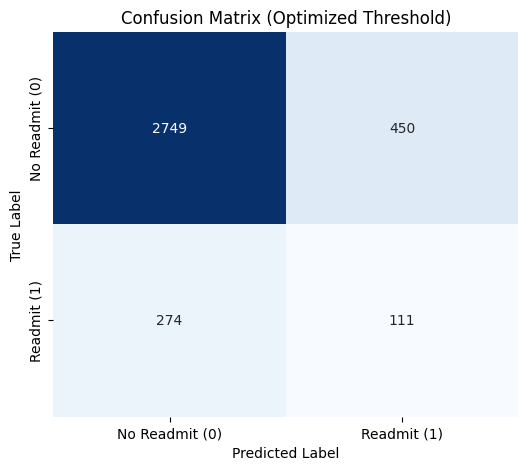

In [ ]:
# --- 1. Compute precision-recall curve ---
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# --- 2. Compute F1 score for each threshold ---
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)  # small epsilon to avoid divide by zero

# --- 3. Find the threshold that maximizes F1 ---
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"Best threshold to maximize F1: {best_threshold:.4f}")
print(f"Corresponding F1 score: {f1_scores[best_idx]:.4f}")

# --- 4. Reclassify predictions using this threshold ---
y_pred_adjusted = (y_proba >= best_threshold).astype(int)

# --- 5. Evaluate model at optimized threshold ---
print("\n--- Classification Report (Optimized Threshold) ---")
print(classification_report(y_test, y_pred_adjusted))

# --- 6. Confusion matrix visualization ---
cm = confusion_matrix(y_test, y_pred_adjusted)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Readmit (0)', 'Readmit (1)'],
            yticklabels=['No Readmit (0)', 'Readmit (1)'])
plt.title('Confusion Matrix (Optimized Threshold)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

